In [1]:
!pip install -U transformers timm --quiet

In [2]:
import torch
import transformers

transformers.__version__

'4.44.0'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Data

## Text

In [4]:
text_data = ["a photo of a dog waling", "a photo of a plane in the sky"]

## Image

In [5]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

image_urls = [
    'https://www.akc.org/wp-content/uploads/2017/11/Golden-Retriever-Puppy.jpg',
    'https://c02.purpledshub.com/uploads/sites/41/2023/07/global-8000-Hero-8af5a4d.jpg'
]

image_data = []

for url in image_urls:
    image_data.append(
        Image.open(requests.get(url, stream=True).raw)
    )

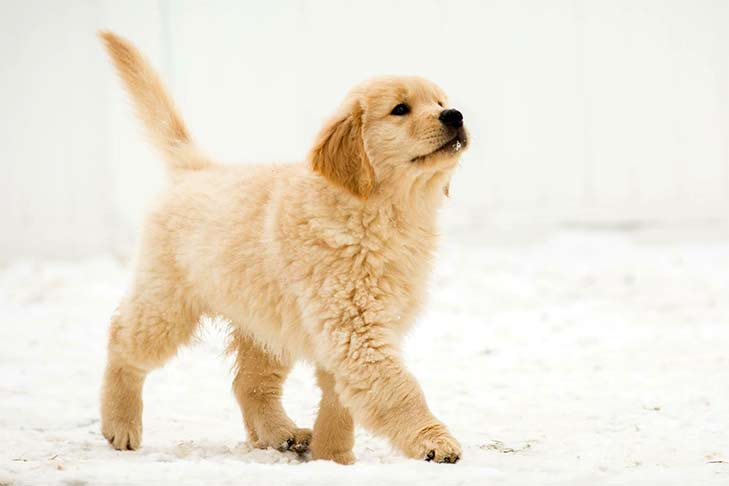

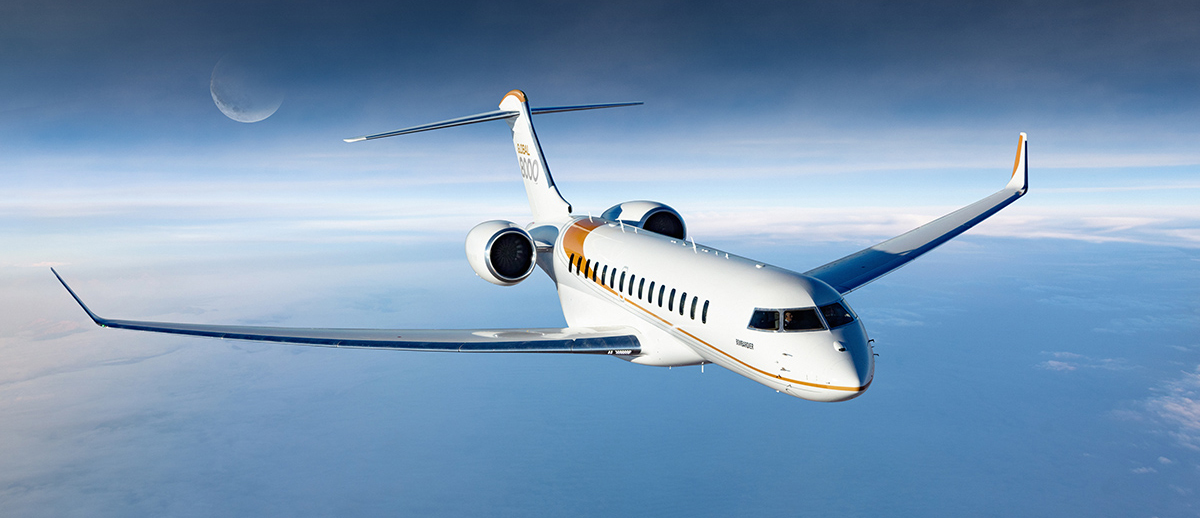

In [6]:
for img in image_data:
    display(img)

# CLIP

## Load model

In [7]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    device_map=device,
    torch_dtype=torch.float16,
)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## tokenize/ process

### Text

In [8]:
inputs: dict = processor(text=text_data, return_tensors="pt", padding=True).to(device)
inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  1929,  1056,   519, 49407, 49407],
        [49406,   320,  1125,   539,   320,  5363,   530,   518,  2390, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
with torch.no_grad():
    text_outputs = model.get_text_features(inputs.input_ids).cpu()

In [10]:
text_outputs.size()

torch.Size([2, 512])

### Image

In [11]:
inputs: dict = processor(images=image_data, return_tensors="pt", padding=True).to(device)
inputs

{'pixel_values': tensor([[[[ 1.6968,  1.6968,  1.6968,  ...,  1.7552,  1.7552,  1.7552],
          [ 1.6968,  1.6968,  1.6968,  ...,  1.7552,  1.7552,  1.7552],
          [ 1.6968,  1.6968,  1.6968,  ...,  1.7552,  1.7552,  1.7552],
          ...,
          [ 1.7698,  1.7406,  1.7114,  ...,  1.7260,  1.7552,  1.7698],
          [ 1.6530,  1.6530,  1.6384,  ...,  1.7114,  1.7406,  1.7552],
          [ 1.5800,  1.5654,  1.5508,  ...,  1.7114,  1.7406,  1.7552]],

         [[ 1.8498,  1.8498,  1.8498,  ...,  1.9098,  1.9098,  1.9098],
          [ 1.8498,  1.8498,  1.8498,  ...,  1.9098,  1.9098,  1.9098],
          [ 1.8498,  1.8498,  1.8498,  ...,  1.9098,  1.9098,  1.9098],
          ...,
          [ 1.9248,  1.8948,  1.8648,  ...,  1.8648,  1.8948,  1.9098],
          [ 1.8047,  1.8047,  1.7897,  ...,  1.8648,  1.8948,  1.9098],
          [ 1.7297,  1.7147,  1.6997,  ...,  1.8648,  1.8948,  1.9098]],

         [[ 1.8473,  1.8473,  1.8473,  ...,  1.9042,  1.9042,  1.9042],
          [ 1

In [12]:
inputs.pixel_values.size()

torch.Size([2, 3, 224, 224])

In [13]:
with torch.no_grad():
    img_outputs = model.get_image_features(inputs.pixel_values).cpu()

In [14]:
img_outputs.size()

torch.Size([2, 512])

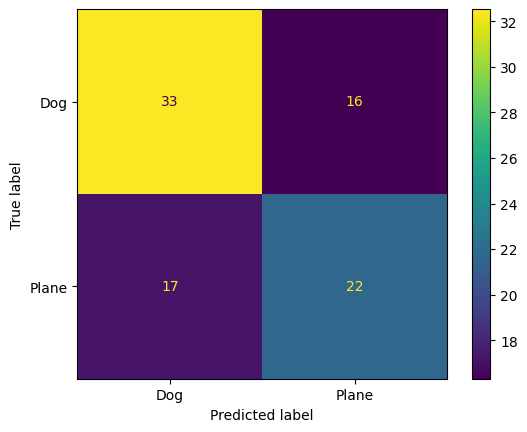

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = (text_outputs @ img_outputs.T).numpy(), display_labels = ["Dog", "Plane"])

cm_display.plot()
plt.show()

# Jina CLIP

In [16]:
from transformers import AutoModel

model = AutoModel.from_pretrained("jinaai/jina-clip-v1", trust_remote_code=True)

In [17]:
text_outputs = model.encode_text(sentences=text_data)
text_outputs.shape

(2, 768)

In [18]:
img_outputs = model.encode_image(image_data)
img_outputs.shape

(2, 768)

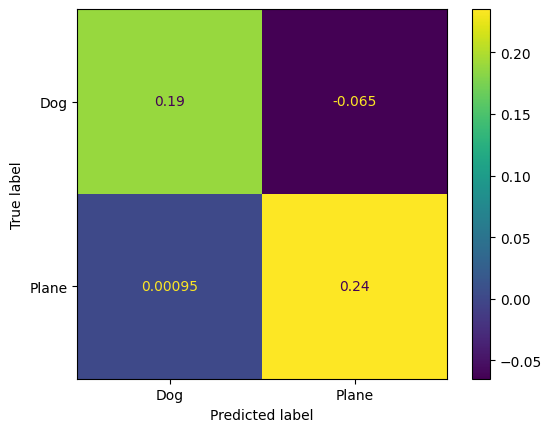

In [19]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = text_outputs @ img_outputs.T, display_labels = ["Dog", "Plane"])

cm_display.plot()
plt.show()